<a href="https://colab.research.google.com/github/christian235711/Method_spad_score/blob/main/Analyse_disqual.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#!pip install fanalysis

from sklearn.metrics import confusion_matrix

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# option d'affichage des résultats
pd.set_option("display.max_row",130)
pd.set_option("display.max_columns",100)

In [3]:
# noms des variables de notre dataset y compris la variable identifiant IRIS
colonnes =["IDENT","TypeHabi", "GeoFaz_Scl", "GeoFaz_cl","Anciennete","Doublon_ligne",
            "Revenus_iris","Sexe","Prenom_Phase_scl_H", "Prenom_Phase_scl_F","Prenom_Phase_cl_H",
           "Prenom_Phase_cl_F","Age_H","Age_F","Pays_sud","Prenom_effectif","codif_RdB","Flag_PA",
           "Annee_1er_don","Cumul_dons","Don_max","Don_moyen","Vingtiles_ISF","IFI+"]

In [4]:
# importation du fichier (changer le chemin d'accès)
''' Faites attention au type de fichier, au délimiteur des valeurs (ça doit être unique et non multiple),
au header et à la lecture des types d'objets (low_memory) '''
#/content/drive/MyDrive/Stage_methods_spad/data_excel_2.csv
data_orig = pd.read_csv("/content/drive/MyDrive/spad_score_method_1/my_data_FDFIFI19.txt",delim_whitespace="\t" , header = None, names=colonnes, low_memory=False, )#, dtype='Int64')

In [5]:
''' copie superficielle (peu profonde) du dataset original pour ne pas modifier les valeurs
d'origine par erreur plus tard 
'''
data = data_orig.copy()
data.shape

(484522, 24)

In [6]:
# visualisation des premiers lignes
data.head()


,IDENT,TypeHabi,GeoFaz_Scl,GeoFaz_cl,Anciennete,Doublon_ligne,Revenus_iris,Sexe,Prenom_Phase_scl_H,Prenom_Phase_scl_F,Prenom_Phase_cl_H,Prenom_Phase_cl_F,Age_H,Age_F,Pays_sud,Prenom_effectif,codif_RdB,Flag_PA,Annee_1er_don,Cumul_dons,Don_max,Don_moyen,Vingtiles_ISF,IFI+
0,101001347,3,75,7,8,3,3,3,64,46,6,4,9,4,2,3,3,2,7,7,6,4,10,2.0
1,201001512,1,74,7,5,3,3,4,65,81,6,8,11,12,2,4,3,2,8,5,2,2,10,2.0
2,301002801,2,32,3,7,2,4,4,66,66,6,6,11,9,2,3,3,2,8,7,5,3,7,2.0
3,401003186,1,12,1,4,3,7,3,51,81,5,8,9,12,2,5,1,2,2,7,8,6,18,2.0
4,501003624,2,12,1,6,3,3,3,51,81,5,8,9,12,2,5,1,2,8,7,8,6,2,2.0


In [60]:
#nombre de modalités de chaque variables (dans un dataframe)
def nombre_mod(data2):
    #création d'un dataframe vide
    dff= pd.DataFrame(columns=["VARIABLE","NOMBRE_MOD", "NOMBRE_MOD_SANS_NA"])
    for i in range(data2.shape[1]): # sans compter les valeurs manquantes
        taille =len(data2.iloc[:,i].value_counts(dropna=False))
        taille_1 = len(data2.iloc[:,i].value_counts(dropna=True) )
        dff=dff.append({"VARIABLE": colonnes[i],"NOMBRE_MOD":taille, "NOMBRE_MOD_SANS_NA":taille_1 }, ignore_index=True)
    return dff


def evaluation(model, X_train, y_train, X_test, y_test, scoring):

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    print("test set : ")
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred)) 
    print("train set : ")
    print(confusion_matrix(y_train, model.predict(X_train))) # ajouter 
    print(classification_report(y_train, model.predict(X_train) ))

    N, train_score, val_score = learning_curve(model, X_train, y_train, cv = 4, scoring = scoring, train_sizes = np.linspace(0.1, 1, 10) )

    plt.figure(figsize = (10,6))
    plt.plot(N, train_score.mean(axis=1), label ="train_score")
    plt.plot(N, val_score.mean(axis=1), label ="cross_validation_score")

    plt.legend()


In [8]:
nombre_mod(data)

,VARIABLE,NOMBRE_MOD,NOMBRE_MOD_SANS_NA
0,IDENT,484522,484522
1,TypeHabi,4,4
2,GeoFaz_Scl,38,38
3,GeoFaz_cl,8,8
4,Anciennete,11,11
5,Doublon_ligne,3,3
6,Revenus_iris,8,8
7,Sexe,5,5
8,Prenom_Phase_scl_H,31,31
9,Prenom_Phase_scl_F,45,45


In [9]:
data["IFI+"].value_counts(dropna=False)

2.0    462833
NaN     19069
1.0      2620
Name: IFI+, dtype: int64

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 484522 entries, 0 to 484521
Data columns (total 24 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   IDENT               484522 non-null  int64  
 1   TypeHabi            484522 non-null  int64  
 2   GeoFaz_Scl          484522 non-null  int64  
 3   GeoFaz_cl           484522 non-null  int64  
 4   Anciennete          484522 non-null  int64  
 5   Doublon_ligne       484522 non-null  int64  
 6   Revenus_iris        484522 non-null  int64  
 7   Sexe                484522 non-null  int64  
 8   Prenom_Phase_scl_H  484522 non-null  int64  
 9   Prenom_Phase_scl_F  484522 non-null  int64  
 10  Prenom_Phase_cl_H   484522 non-null  int64  
 11  Prenom_Phase_cl_F   484522 non-null  int64  
 12  Age_H               484522 non-null  int64  
 13  Age_F               484522 non-null  int64  
 14  Pays_sud            484522 non-null  int64  
 15  Prenom_effectif     484522 non-nul

In [11]:
""" 
for i in range(data.shape[0]):
    if data.iloc[i,23] == 1.0:
        data.iloc[i,23] = 1
    if data.iloc[i,23] == 2.0:
        data.iloc[i,23] = 2    
"""


' \nfor i in range(data.shape[0]):\n    if data.iloc[i,23] == 1.0:\n        data.iloc[i,23] = 1\n    if data.iloc[i,23] == 2.0:\n        data.iloc[i,23] = 2    \n'

In [18]:

!pip install fanalysis

     |████████████████████████████████| 61kB 3.1MB/s 


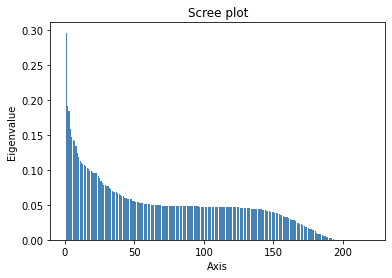

None


In [19]:
#importation de la librairie
from fanalysis.mca import MCA

#instanciation
acm = MCA(var_labels=data.columns[1:22])

# apprentissage
acm.fit(data.iloc[:,1:22].values)
#valeurs propres - graphique
print(acm.plot_eigenvalues())

In [20]:
# fonction qui va diviser et calculer les coordonnées des individus 
def transform_to_coord(data):
    coord_part = 0
    coord = acm.transform(data.iloc[0:30000,1:22].values)
    k=30000
    nb_part = round(data.shape[0]/k)
    for i in range(1, nb_part):
        coord_part=acm.transform(data.iloc[i*k:(i+1)*k,1:22].values)
        coord=np.concatenate((coord, coord_part))

    coord_part = acm.transform(data.iloc[nb_part*k: ,1:22].values )
    coord=np.concatenate((coord, coord_part))
    return coord

In [21]:
#instanciation
acm = MCA(var_labels = data.columns[1:22], n_components=10)  # paramètres index manquante (gérer après)
#apprentissage 
"ne pas utiliser fit_tranform car le datset est trop grand "
acm.fit(data.iloc[:,1:22].values)

# tranformation du dataset
coord = transform_to_coord(data)


In [111]:
coord.shape

(484522, 10)

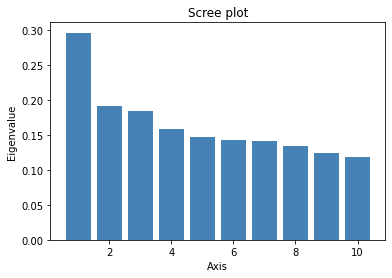

None


In [22]:
#valeurs propres - graphique
print(acm.plot_eigenvalues())


In [23]:
#coordonnées des colonnes
print(acm.col_topandas())

               col_coord_dim1  col_coord_dim2  col_coord_dim3  col_coord_dim4  \
TypeHabi_1           0.308043        0.028056       -0.254317        0.332794   
TypeHabi_2          -0.149051       -0.009896        0.121627       -0.156493   
TypeHabi_3           0.098735       -0.019673        0.001603        0.093629   
TypeHabi_4           0.417201        0.409048       -3.242082        0.055550   
GeoFaz_Scl_11       -0.201365        0.045000       -0.173145        0.279897   
...                       ...             ...             ...             ...   
Don_moyen_3         -0.044906       -0.253525        0.172224       -0.061992   
Don_moyen_4         -0.069381       -0.180796       -0.093701        0.196824   
Don_moyen_5         -0.250145       -0.237229        0.048370        0.593057   
Don_moyen_6         -0.216658       -0.124886       -0.361856        0.729102   
Don_moyen_7          0.118912        4.735208        1.358792        0.202226   

               col_coord_di

In [24]:
#nombre var. actives
p = data.shape[1]-1
print(p)
#calcul des fonctions de projection
fproj = np.zeros(acm.col_coord_.shape)
#pour chaque colonne
for j in range(fproj.shape[1]):
 fproj[:,j] = acm.col_coord_[:,j]/(p*np.sqrt(acm.eig_[0,j]))
#affichage fonction
print(fproj)
#affichage plus avenant des deux premiers facteurs
print(pd.DataFrame(fproj,index=acm.col_labels_))


23
[[ 2.45920468e-02  2.78807170e-03 -2.57453499e-02 ...  2.32744577e-02
  -2.38198269e-02  3.90063672e-02]
 [-1.18992358e-02 -9.83387525e-04  1.23127577e-02 ... -1.19626106e-02
   1.04386280e-02 -1.59784384e-02]
 [ 7.88235137e-03 -1.95498606e-03  1.62296163e-04 ...  1.07773864e-02
  -4.34429347e-03  1.16066606e-03]
 ...
 [-1.99698880e-02 -2.35744363e-02  4.89668270e-03 ...  1.43954529e-02
   3.07460503e-02 -7.20326405e-02]
 [-1.72965077e-02 -1.24104320e-02 -3.66318983e-02 ...  1.24679507e-02
   2.36223346e-02 -5.48491086e-02]
 [ 9.49311717e-03  4.70557693e-01  1.37555005e-01 ...  1.05151280e-02
  -1.15955158e-02 -2.90521772e-03]]
                      0         1         2         3         4         5  \
TypeHabi_1     0.024592  0.002788 -0.025745  0.036371 -0.018189  0.053691   
TypeHabi_2    -0.011899 -0.000983  0.012313 -0.017103  0.004392 -0.026189   
TypeHabi_3     0.007882 -0.001955  0.000162  0.010233 -0.014163  0.027746   
TypeHabi_4     0.033307  0.040649 -0.328207  0.006071

(484522, 10)


In [26]:
#10 premières lignes
print(coord[:10,:])


[[ 0.0119508  -0.00148098 -0.34336444 -0.11481482 -0.04560869  0.56645452
  -0.10758517 -0.15917103 -0.72617124 -0.57766009]
 [-0.30068904 -0.13199317  0.1444261  -0.39628891  0.04059033  0.48912828
  -0.39023196  0.50556192 -0.22457525  0.20094984]
 [ 0.00875939 -0.20144055  0.53936513 -0.61389877  0.23318113  0.60113673
  -0.09632512 -0.123426    0.39695427 -0.16869507]
 [-0.73008063 -0.08973934 -0.09085613  0.54656231 -0.03672979  0.23185405
  -0.53703945 -0.30244295 -0.26140384 -0.25367165]
 [-0.78608946 -0.11895905  0.02729426  0.50177151  0.05163984  0.13162223
  -0.49094473 -0.29944757 -0.20388121 -0.32833799]
 [-0.60765227 -0.07394311 -0.12945368  0.62357147 -0.05577838  0.35957461
  -0.05762383  0.42547987  0.40716881 -0.06549388]
 [ 0.47676365 -0.22754413  0.44213408  0.10391917  0.18291539 -0.07550087
  -0.17280614 -0.39201697  0.35926374  0.09429823]
 [-0.67371076 -0.14634389  0.03029345  0.46079629 -0.03385783  0.0729178
  -0.35318577 -0.20726202 -0.09530929 -0.26292359]
 

In [126]:
print(data_sans_nan.shape)
print(coord_sans_nan.shape)
print(data_sans_nan.iloc[:,0])
dfff.isnull().sum(axis=0)

(465453, 24)
(465453, 10)
0              101001347
1              201001512
2              301002801
3              401003186
4              501003624
               ...      
466512    46651304217222
466513    46651404217223
466514    46651504217224
466515    46651604217225
466516    46651704217227
Name: IDENT, Length: 465453, dtype: int64


IDENT    0
0        0
1        0
2        0
3        0
4        0
5        0
6        0
7        0
8        0
9        0
IFI+     0
dtype: int64

In [128]:

# élimination des individus n'ayant pas de valeur pour la varialbe IFI+
data_sans_nan = data[(data.isnull()).sum(axis=1) == 0]
coord_sans_nan = coord[(data.isnull()).sum(axis=1) == 0]

dfff = pd.DataFrame()
dfff["IDENT"] = data_sans_nan.iloc[:,0]
for i in range(10):
    dfff[str(i)]=coord_sans_nan[:,i]
dfff["IFI+"] = data_sans_nan.iloc[:,23].astype(int)

data_coord_nan = dfff

In [129]:
dfff.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 465453 entries, 0 to 466516
Data columns (total 12 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   IDENT   465453 non-null  int64  
 1   0       465453 non-null  float64
 2   1       465453 non-null  float64
 3   2       465453 non-null  float64
 4   3       465453 non-null  float64
 5   4       465453 non-null  float64
 6   5       465453 non-null  float64
 7   6       465453 non-null  float64
 8   7       465453 non-null  float64
 9   8       465453 non-null  float64
 10  9       465453 non-null  float64
 11  IFI+    465453 non-null  int64  
dtypes: float64(10), int64(2)
memory usage: 46.2 MB


In [130]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn.metrics import f1_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, learning_curve, GridSearchCV, RandomizedSearchCV

In [131]:
#data_non_corr = elimination_val_corr(data)
#nb_var = data_non_corr.shape[1] - 1
nb_var = data_coord_nan.shape[1] - 1

train_set, test_set = train_test_split(data_coord_nan, test_size = 0.2, random_state=0 )

train_X_s = (train_set.iloc[:,1:nb_var]).to_numpy()
train_Y_s = np.asanyarray(train_set.iloc[:,nb_var])

test_X_s = (test_set.iloc[:,1:nb_var]).to_numpy()
test_Y_s = np.asanyarray(test_set.iloc[:,nb_var])


test set : 
[[    0   498]
 [    5 92588]]
              precision    recall  f1-score   support

           1       0.00      0.00      0.00       498
           2       0.99      1.00      1.00     92593

    accuracy                           0.99     93091
   macro avg       0.50      0.50      0.50     93091
weighted avg       0.99      0.99      0.99     93091

train set : 
[[     0   2122]
 [    15 370225]]
              precision    recall  f1-score   support

           1       0.00      0.00      0.00      2122
           2       0.99      1.00      1.00    370240

    accuracy                           0.99    372362
   macro avg       0.50      0.50      0.50    372362
weighted avg       0.99      0.99      0.99    372362



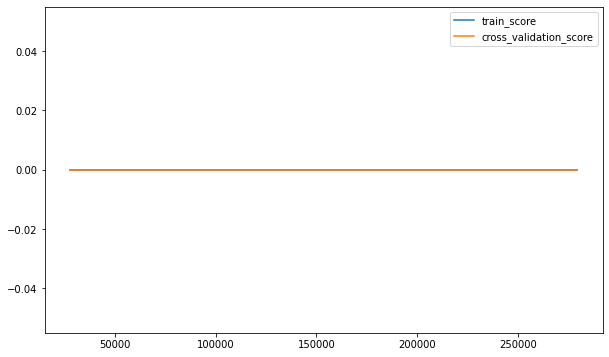

In [133]:
model_17 = LinearDiscriminantAnalysis(store_covariance=True )
evaluation(model_17, train_X_s, train_Y_s, test_X_s, test_Y_s, scoring = "recall")

In [54]:
#classe pour l'analyse discriminante

#instanciation
adl = LinearDiscriminantAnalysis()
#apprentissage
adl.fit(coord_sans_nan,data_sans_nan["IFI+"])

LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001)

In [59]:
#reconstitution de la fonction sur indicatrices (multiplication)
fpValues = np.dot(fproj,np.transpose(adl.coef_))
#print(fpValues)
#affichage plus joli
print(pd.DataFrame(fpValues,index=acm.col_labels_))

                      0
TypeHabi_1    -0.288108
TypeHabi_2     0.144834
TypeHabi_3    -0.132385
TypeHabi_4     0.071164
GeoFaz_Scl_11 -0.034166
...                 ...
Don_moyen_3    0.324096
Don_moyen_4    0.206657
Don_moyen_5   -0.250813
Don_moyen_6   -0.268574
Don_moyen_7   -7.390598

[240 rows x 1 columns]


In [46]:
aaaa = np.array([[2,3],[4,6], [3,3], [5,5]])
aaaa

array([[2, 3],
       [4, 6],
       [3, 3],
       [5, 5]])

In [51]:
aaaa[[True,False,False, True]]

array([[2, 3],
       [5, 5]])

array([[ 3, 75,  7, ...,  7,  6,  4],
       [ 1, 74,  7, ...,  5,  2,  2],
       [ 2, 32,  3, ...,  7,  5,  3],
       ...,
       [ 2, 63,  6, ...,  8,  9,  7],
       [ 2, 11,  1, ...,  8,  9,  7],
       [ 2, 37,  3, ...,  8,  9,  7]])

In [ ]:

'''
from sklearn.preprocessing import KBinsDiscretizer
# discrétisation des variables continues (les valeurs manquantes doivent être gérées en amont)
 c'est qui est bien avec KBinsDiscretizer est qu'il s'adapte aux éventuelles partitions au
sein d'une variable. En d'autres termes, si la méthode n'arrive pas à partitionner les individus
en k partitions, alors elle esssayera de les partitionner en k-1 partitions, et ainsi de suite, 
jusqu'à atteindre 1 partition (il faut faire attention avec les variables ayant uniquement 
une modalité). Lorsque la méthode rencontre ce cas, elle affichera "UserWaring" pour informer 
l'utilisateur de celui-ci ainsi que les variables concernées. Ceci sera utile plus tard.


method_discre = KBinsDiscretizer(n_bins=4, encode='ordinal', strategy='quantile') 
method_discre.fit(data.iloc[:,1:23])
resultat_discre = method_discre.transform(data.iloc[:,1:23])
resultat_discre

# construction du data frame après discrétisation
data2_index = data.iloc[:,0]
df_resultat_discre = pd.DataFrame(resultat_discre,columns=colonnes[1:23], dtype=int )
data_final = pd.concat([data2_index, df_resultat_discre,data["IFI+"]], axis=1 ) #data2_index
data_final

#nombre_mod(data_final)
#nombre_mod(data)

# description des modalités d'une variable
for k in range(1,data_final.shape[1]):
    print(data_final.iloc[:,k].value_counts(dropna=True)); print("="*50)

# description des modalités d'une variable
for k in range(1,data.shape[1]):
    print(data.iloc[:,k].value_counts(dropna=True)); print("="*50)

'''


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:197: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  'decreasing the number of bins.' % jj)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:197: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 4 are removed. Consider decreasing the number of bins.
  'decreasing the number of bins.' % jj)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:197: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 6 are removed. Consider decreasing the number of bins.
  'decreasing the number of bins.' % jj)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:197: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 7 are removed. Consider decreasing the number of bins.
  'decreasing the number of bins.

array([[1., 3., 3., ..., 3., 2., 1.],
       [0., 3., 3., ..., 1., 1., 1.],
       [1., 1., 1., ..., 2., 2., 1.],
       ...,
       [1., 2., 2., ..., 3., 3., 1.],
       [1., 0., 0., ..., 3., 3., 1.],
       [1., 1., 1., ..., 3., 3., 1.]])